# Chapter 3 - Classification


## MNIST

In [1]:
#Load MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

In [5]:
#the data set consists of 784 features, corresponding to pixel intesities of a 28x28 image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
display(type(some_digit))


numpy.ndarray

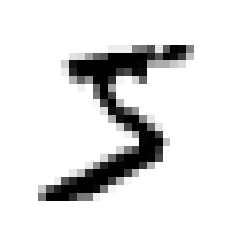

In [6]:
#reshape the above vector into a 28x28 grid
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()

In [7]:
display(y[0]) #confirm what the image is
display(type(y[0])) #show that its a string

'5'

str

In [8]:
import numpy as np

#cast the label columns to integers
y = y.astype(np.uint8)

## Training a Binary Classifier

Identify a '5' using a Stochastic Gradient Descent (SGD) Classifier

In [9]:
#split into test and training set
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_5 = (Y_train == 5)
y_test_5 = (Y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

We'll use cross validation to measure the accuracy of the SGD model. Then compare it with the cross validation of a static model to show why accuracy isn't a good measurement for classification. The static model simply predicts a False value regardless of input.

#### Implementing Cross-Validation Manually
Write a cross implementation function for practice

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def cross_validation_manual(X_train, y_train_5):
    skfolds = StratifiedKFold(n_splits=3, random_state=42)
    for train_index, test_index in skfolds.split(X_train, y_train_5):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]

        clone_clf.fit(X_train_folds, y_train_folds)
        #predict
        y_predict = clone_clf.predict(X_test_fold)
        #number of correct
        n_correct = sum(y_predict == y_test_fold)
        #print correct ratio
        print(n_correct/len(y_predict))
    


In [14]:
display(len(X_train))
display(len(y_train_5))

60000

60000

In [15]:
cross_validation_manual(X_train, y_train_5)

0.95035
0.96035
0.9604


#### Evaluate SGD Accuracy using Cross Validation 

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Now we create a model that predicts false regardless of input data to demonstrate why accuracy is not a good measurement of classification. The data is mostly not 5's. Therefore, a trivially False prediction will score high with an accuracy measure.

In [17]:
from sklearn.base import BaseEstimator

class Never5Class(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never5classifier = Never5Class()
cross_val_score(never5classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

About 90% of the y_train_5 values are false. So a trivially False prediction will yield atleast 90% accuracy.

In [19]:
display(sum(y_train_5 == False)/len(y_train_5))

0.90965

### Confusion Matrix

In [20]:
#What does cross_val_predict return?
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

Precision and Recall are measures used together in binary classification that tells us how precise our positive predictions are and how many likely our model is to label something as positive.  

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
#evaluate score of some digit using the decision_function()
y_scores = sgd_clf.decision_function([some_digit])
display(y_scores)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
display(y_some_digit_pred)

array([2164.22030239])

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [33]:
#whats does -1 index do ??
f = [1, 2,3,4,5]
f[:-2]

[1, 2, 3]

In [61]:
#get values for plotting
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [62]:
print(len(thresholds))
print(len(recalls))
print(len(precisions))

59966
59967
59967


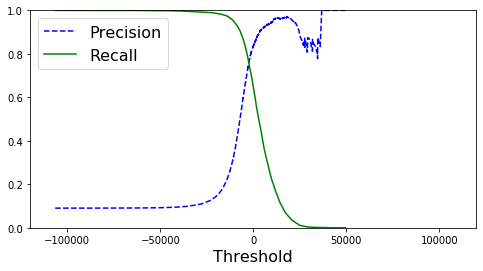

In [63]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-120000, 120000])
plt.show()

In [64]:
#use np.argmax to get first index of  of >= 90% score
print(np.argmax(precisions >= 0.90))
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

57075
3370.0194991439557


In [50]:
len(y_train_pred)

60000

In [56]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
len(y_train_pred_90)

60000

In [58]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [57]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [68]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [60]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706